### Main objective of this notebook: Compute an accuracie score for each player for each game
 Define an accurarie score and compare it to the score provided by chess.com (correlation analysis)

In [1]:
import pandas as pd
import numpy as np
import chess.pgn
import io
from stockfish import Stockfish
import matplotlib.pyplot as plt


stockfish = Stockfish(r'C:\Users\User\Desktop\stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2.exe')

pd.set_option('display.max_columns', 250)


In [2]:
game_df = pd.read_pickle('./data/full_games_history.pkl')
# game_df.head()

In [3]:
# Keep only games where chess.com provided an accuracy
sub_game_df = game_df.loc[~game_df['white_accuracie'].isnull()].reset_index(drop=True)
sub_game_df.shape

(2387, 46)

### First score based on if player played a move among top n moves given by Stockfish (default settings)

In [4]:
def score_topn_moves(game, top_n_move):
    white_played_is_topn = 0
    black_played_is_topn = 0
    nb_of_moves = 0
    for g in game.mainline_moves():
        pos = game.board().fen()
        stockfish.set_fen_position(pos)
        topn_moves = pd.DataFrame(stockfish.get_top_moves(top_n_move))['Move'].tolist()
        played_move = str(game.next().move) 

        if (game.turn() == True) & (played_move in topn_moves): #Is white played a move in the topn move
            white_played_is_topn += 1
        elif (game.turn() == False) and (played_move in topn_moves): #Is black played a move in the topn move
            black_played_is_topn += 1
        
        nb_of_moves += 1
        game = game.next()
    
    white_score = white_played_is_topn / nb_of_moves
    black_score = black_played_is_topn / nb_of_moves

    return white_score, black_score

In [107]:
# Unitary testing of score_topn_moves function
pgn = io.StringIO(sub_game_df['pgn'].iloc[0])
game = chess.pgn.read_game(pgn)
print(score_topn_moves(game))

(0.5102040816326531, 0.6938775510204082)


In [24]:
# Loop through a given number of game => Limitation is due to computing needed (0.5 min / game => ~2300 games ~= 20h of processing...)

# white_acc = []
# black_acc = []
# i = 0
# stop = 40

# for i, d in sub_game_df.iterrows():
#     pgn = io.StringIO(str(d['Moves']))
#     game = chess.pgn.read_game(pgn)
#     w_acc, b_acc = score_topn_moves(game)
#     white_acc.append(w_acc)
#     black_acc.append(b_acc)   
#     if i == stop:
#         break
#     else:
#         i += 1


In [29]:
computed_accuracies = pd.DataFrame()

convert_to_stringio = sub_game_df.iloc[:120]['Moves'].apply(io.StringIO)
read_game = convert_to_stringio.apply(chess.pgn.read_game)

computed_accuracies['computed'] = read_game.apply(lambda x: score_topn_moves(x,3))

# computed_accuracies

In [40]:
computed_accuracies = pd.DataFrame(computed_accuracies['computed'].tolist()).rename(columns={0: 'white', 1:'black'})
computed_accuracies.to_csv('./data/computed_accuracies_topn_moves.csv')

In [45]:
computed_accuracies = pd.read_csv('./data/computed_accuracies_topn_moves.csv', index_col=0)*100
computed_accuracies.head()

,white,black
0,28.301887,20.754717
1,41.025641,23.076923
2,25.641026,28.205128
3,35.483871,29.032258
4,39.024390,26.829268


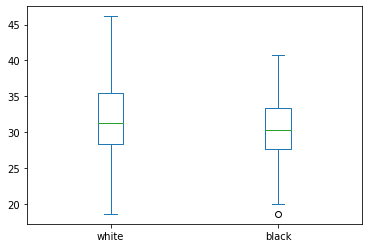

In [32]:
# Correlation analysis of score_topn_moves vs accuracie score provided by chess.com

# See distribution for computed accuracies
computed_accuracies.plot(kind='box')
plt.show()


In [34]:
computed_accuracie = pd.concat([computed_accuracies['white'], computed_accuracies['black']], axis=0).reset_index(drop=True)
reel_accuracie = pd.concat([sub_game_df['white_accuracie'].iloc[:120], sub_game_df['black_accuracie'].iloc[:120]], axis=0).reset_index(drop=True)

corr_df = pd.DataFrame({'reel': reel_accuracie, 'computed': computed_accuracie})

correlation = corr_df.corr()

print(correlation)

             reel  computed
reel      1.00000   0.59161
computed  0.59161   1.00000


In [55]:
correlation.loc['computed', 'reel'] 
# 0.59 means we have a strong correlation between the computed accuracie and chess.com accuracie

0.5916097018432916

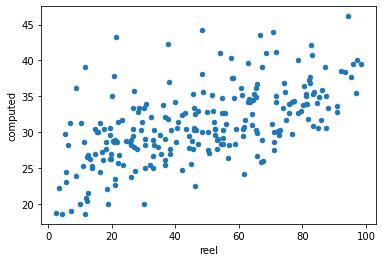

In [35]:
corr_df.plot(x='reel', y='computed', kind='scatter')
plt.show()

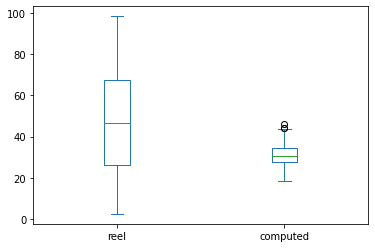

In [36]:
corr_df.plot(kind='box')
plt.show()

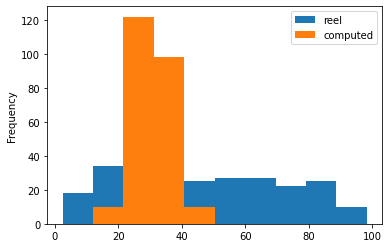

In [37]:
corr_df.plot(kind='hist')
plt.show()

### Conclusion

Chess.com does not provide for each game played the player's accuracie, actually it is provided in the API only if the player we are analyzing has specificly requested at the end of the game an analysis (premium account needed) 

Since we are not able to always get this data, which seem important for further analysis, the goal was to computed a custom score of accuracie and compare it to the accuracie provided by chess.com

The score computed was calculated by checking for each game and move if the player is playing one of the top 3 moves suggested by Stockfish engine. Once calculated for a subset of games it appears this score is well correlated (0.59 pearson) with the chess.com accuracie. 

However, calculating such score is greedy (looping though each game moves...) which limits it usage for a large dataset. So, if accuracie is requested for analysis the pragmactic option will be to limit the analysis for games already having a accuracie provided by chess.com



N.B : Options/Ideas to improve this score correlation or performance :
1. Compute an accuracie score based on centipawn difference between played and best move given by Stockfish
2. Limit the analysis to best move given by Stockfish (top 1 move)

### Test of stockfish module

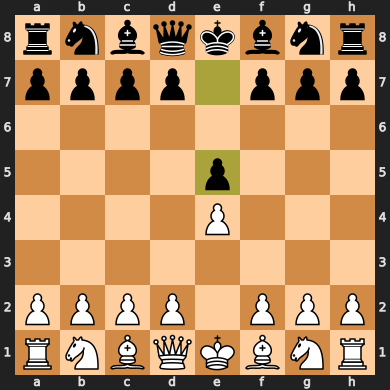

In [166]:
# pgn = game_df.reset_index(drop=True)['pgn'].iloc[0]


# output_df = pd.DataFrame()

# for index, row in game_df.iterrows():
#     pgn = io.StringIO(row.pgn)
#     game = chess.pgn.read_game(pgn)
#     a = pd.DataFrame([game.headers[header] for header in game.headers]).T
#     a.columns = game.headers
#     output_df = pd.concat([output_df, a], axis=1)
# output_df.head()

# pgn = game_df.pgn.iloc[0]
# pgn = io.StringIO(pgn)
# game = chess.pgn.read_game(pgn)
# moves = game.mainline_moves()


# stockfish = Stockfish()

# pgn = io.StringIO(game_df['pgn'].iloc[0])

# game = chess.pgn.read_game(pgn)

# game_end = game.end()

# board = game.board()

# game.next().next().board()


# for move in game.mainline_moves():
#     print(board.san(move))
#     board.push(move)


In [226]:
# for m in game.mainline_moves():
#     print(m)


# print(game_df.time_control.iloc[0])

# a = game

# for i in range(10):
#     print(a.clock(), a.move, a.board().fen())
#     a = a.next()
#     pos = a.board().fen()

# print(pos)


In [106]:
# from stockfish import Stockfish

# stockfish = Stockfish(r'C:\Users\User\Desktop\stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2.exe')

# pgn = io.StringIO(game_df['pgn'].iloc[0])

# game = chess.pgn.read_game(pgn)

# a = game
# b = 0
# for i in range(50):
#     pos = a.board().fen()
#     stockfish.set_fen_position(pos)
#     d = pd.DataFrame(stockfish.get_top_moves(3))['Move'].tolist()

#     # print(a.turn(), a.next().clock(), a.next().move, d, str(a.next().move) in d) #, a.board().fen())
#     # print(str(a.next().move) in [i['Move'] for i in stockfish.get_top_moves(3)], '\n')
    
#     # print(a.board())
#     # print(stockfish.get_evaluation(), stockfish.get_best_move(), stockfish.get_top_moves(3),'\n')
#     if (str(a.next().move) in d) != (str(a.next().move) in [i['Move'] for i in stockfish.get_top_moves(3)]):
#         print(a.turn(), a.next().clock(), a.next().move, d, str(a.next().move) in d) #, a.board().fen())
#         print(str(a.next().move) in [i['Move'] for i in stockfish.get_top_moves(3)], '\n')
#         b += 1
#     a = a.next()

# print(b)

True 594.9 b1c3 ['f1b5', 'd2d4', 'f1c4'] False
True 

False 578.1 f8e7 ['c6a5', 'g7g6', 'a7a6'] False
True 

2
